## Transfer Learning

In practice, **very few people train an entire Convolutional Network from scratch**, because it is relatively rare to have a dataset of sufficient size. Instead, it is common to **use a pretrained a CNN on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories)**, and then use the CNN either as an **initialization or a fixed feature extractor** for the task of interest to us.

![images](images/tf1.png)

* **Pretrained models**. Since modern CNNs take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final parameters for the benefit of others. In the previous notebook we already saw how to use a pretrained model from PyTorch's `torchvision` module.

There are two main ways to do transfer learning with a pre-trained model:

* **Feature Extraction**.  Take a CNN pretrained on ImageNet, remove the last linear layers, then treat the remaining of the CNN as a feature extractor for the new dataset. In an AlexNet for example, this would compute a 4096-D vector for every image. We call these features CNN codes. Once you extract the 4096-D codes for all images, train a standard classifier (i.e. Logistic Regression or Random Forest).

* **Fine-Tuning**. The second strategy is to not only replace and retrain the classifier on top of the CNN on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the training on our new dataset. It is possible to fine-tune all the layers of the CNN, or it's possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune the later layers.

In the case of the VGG architecture, this is a diagram of what the network looks like:

![images](images/tf2.png)


#### When and how to do transfer learning?

* **How much data do you have?**. If you have a small dataset, it is not a good idea to fine-tune a full CNN. Instead, you should use feature extraction, training a linear classifier on top of the CNN codes.

* **How similar is the data to the pretrained data?**. If your new dataset is very different from the dataset on which the original model was trained, it may be better to train a new CNN from scratch.

#### Why to do transfer learning?

The main advantage of transfer learning is the ability to empower you to achieve better accuracy on your tasks. We can break down its advantages as follows:

* **Training efficiency**: When you start with a pre-trained model that has already learned the general features of the data, you then only need to fine-tune the model to your specific task, which can be done much more quickly (i.e. using fewer training epochs).
* **Model accuracy**: Using transfer learning can give you a significant performance boost compared to training a model from scratch using the same amount of resources. Choosing the right pre-trained model for transfer-learning for your specific task is important though.
* **Training data size**: Since a pre-trained model would have already learned to identify many of the features that overlap with your task-specific features, you can train the pre-trained model with less domain-specific data. This is useful if you don’t have as much labeled data for your specific task.

### Transfer Learning with Pytorch: extracting features from a CNN

The process is straightforward. We first start with a pre-trained CNN, for example EfficientNet-B4.

In [1]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# Step 1: Initialize model with the best available weights
weights = EfficientNet_B4_Weights.DEFAULT
model = efficientnet_b4(weights=weights)
model.eval()  # disables gradient calculation for inference.

# Step 2: Initialize the preprocess function
preprocess = weights.transforms()

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

We want to output the names of the layers with the folowing function:

In [3]:
get_graph_node_names(model)

(['x',
  'features.0',
  'features.1.0.block.0',
  'features.1.0.block.1',
  'features.1.0.block.2',
  'features.1.1.block.0',
  'features.1.1.block.1',
  'features.1.1.block.2',
  'features.1.1.stochastic_depth',
  'features.1.1.add',
  'features.2.0.block.0',
  'features.2.0.block.1',
  'features.2.0.block.2',
  'features.2.0.block.3',
  'features.2.1.block.0',
  'features.2.1.block.1',
  'features.2.1.block.2',
  'features.2.1.block.3',
  'features.2.1.stochastic_depth',
  'features.2.1.add',
  'features.2.2.block.0',
  'features.2.2.block.1',
  'features.2.2.block.2',
  'features.2.2.block.3',
  'features.2.2.stochastic_depth',
  'features.2.2.add',
  'features.2.3.block.0',
  'features.2.3.block.1',
  'features.2.3.block.2',
  'features.2.3.block.3',
  'features.2.3.stochastic_depth',
  'features.2.3.add',
  'features.3.0.block.0',
  'features.3.0.block.1',
  'features.3.0.block.2',
  'features.3.0.block.3',
  'features.3.1.block.0',
  'features.3.1.block.1',
  'features.3.1.block

Notice the last layers of the network are:

```
'flatten',
'classifier.0',
'classifier.1']
```

That is, after the convolutional layers, we have a flatten layer, and then two linear layers to perform the classification.

* The classification layers are not interesting to use, because they are specialized for the ImageNet dataset (1000 clases). We will remove them and use the rest of the network as a feature extractor.
* So we only use the output of the flatten layer as the features of our data.

To do this, we will use the following code:

In [4]:
layer_before_final_classifiers = 'flatten'

return_nodes = {
    layer_before_final_classifiers: layer_before_final_classifiers
}

In [5]:
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

Now, `feature_extractor`, is just the convolutional layers of the network, and we can use it to extract features from our data, and compute a better representation.

#### Examples with some input images

In [6]:
from torchvision.io import read_image
import torch

In [7]:
img = read_image('images/husky.png')

image_processed = preprocess(img).unsqueeze(0)

print(image_processed.shape)

torch.Size([1, 3, 380, 380])


Since the images are RGB, the input to the network is a tensor of shape `(1, 3, 380, 380)`. We need to add a singleton dimension to the input tensor, because the network expects a batch of images, and we only have one image. So this is just a way of adding a batch dimension to the input tensor.

We can use the `feature_extractor` to extract the features of the images.

In [8]:
cnn_code = feature_extractor(image_processed)[layer_before_final_classifiers]

In [9]:
cnn_code.shape

torch.Size([1, 1792])

Notice now the dimensions change:

* 1 because we only have one image in our batch
* 1792 because that is the number of remaining dimensions after the convolutional layers. 

So instead of representing our images with 380x380x3=433200 dimensions, we can represent them with 1792 dimensions, which is a much more compact representation.

We can also work with several images at the same time, in a single batch. 

In [10]:
imgs_processed = []

for img_path in ['images/husky.png', 'images/bank.png']:
    img = read_image(img_path)
    img_processed = preprocess(img)
    imgs_processed.append(img_processed)

imgs_processed = torch.stack(imgs_processed)

In [11]:
imgs_processed.shape

torch.Size([2, 3, 380, 380])

In [12]:
cnn_codes = feature_extractor(imgs_processed)[layer_before_final_classifiers]

In [13]:
cnn_codes.shape

torch.Size([2, 1792])

Now we are working with a batch of 2 images.

## Practical Example: Human Presence Analysis in Stock Images

Unlocking Sales Potential with **Human Features Presence Analysis**.

The primary goal of this example is to develop a model to assist the sales/marketing and studio departments at a fashion firm (Parfois). This model will offer a clear overview of the presence of human models for different products on their website, ultimately allowing informed decision-making.

![image](images/parfois.png)

1. First, we will load a csv with the image paths and the corresponding labels (human presence or not).

We have around 70 labeled images, which is a very small dataset. We will use transfer learning to solve this problem.

In [1]:
import pandas as pd

df = pd.read_csv('data_parfois/images_labels.csv', sep=';')

In [2]:
df.head()

,image_file_name,label,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,216394_BM_1y.jpg,1,NaN,NaN,NaN
1,216394_BM_2yf.jpg,0,NaN,NaN,NaN
2,216394_BM_3y.jpg,1,NaN,NaN,NaN
3,216394_BM_4y.jpg,0,NaN,NaN,NaN
4,216394_BM_5y.jpg,1,NaN,NaN,NaN


<AxesSubplot: xlabel='label'>

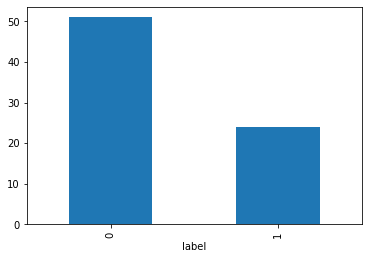

In [3]:
df.value_counts('label').plot(kind='bar')

1. We use a pretrained CNN to extract the features from the images, one by one.

Finally, we will store it in a single tensor

In [4]:
import torch
from torchvision.io import read_image
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# Step 1: Initialize model with the best available weights
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
model.eval()  # disables gradient calculation for inference.

# Step 2: Initialize the preprocess function
preprocess = weights.transforms()


layer_before_final_classifiers = 'flatten'

return_nodes = {
    layer_before_final_classifiers: layer_before_final_classifiers
}

feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/victorgallego/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 17.6MB/s]


In [5]:
image_names = df['image_file_name'].values

cnn_codes = []
for i, image_name in enumerate(image_names):
    print(f'Processing image {i+1}/{len(image_names)}')
    with torch.no_grad():
        img = read_image(f'data_parfois/{image_name}')
        img_processed = preprocess(img).unsqueeze(0)
        cnn_code = feature_extractor(img_processed)[layer_before_final_classifiers]
    cnn_codes.append(cnn_code)


cnn_codes = torch.cat(cnn_codes)  # stack all the processed tensors into a single tensor    

Processing image 1/75


Processing image 2/75
Processing image 3/75
Processing image 4/75
Processing image 5/75
Processing image 6/75
Processing image 7/75
Processing image 8/75
Processing image 9/75
Processing image 10/75
Processing image 11/75
Processing image 12/75
Processing image 13/75
Processing image 14/75
Processing image 15/75
Processing image 16/75
Processing image 17/75
Processing image 18/75
Processing image 19/75
Processing image 20/75
Processing image 21/75
Processing image 22/75
Processing image 23/75
Processing image 24/75
Processing image 25/75
Processing image 26/75
Processing image 27/75
Processing image 28/75
Processing image 29/75
Processing image 30/75
Processing image 31/75
Processing image 32/75
Processing image 33/75
Processing image 34/75
Processing image 35/75
Processing image 36/75
Processing image 37/75
Processing image 38/75
Processing image 39/75
Processing image 40/75
Processing image 41/75
Processing image 42/75
Processing image 43/75
Processing image 44/75
Processing image 45

Let's check the shapes

In [6]:
cnn_codes_numpy = cnn_codes.numpy()
cnn_codes_numpy.shape

(75, 1280)

In [7]:
labels = df.label.values

len(labels)

75

3. Now, we can continue with sklearn, to make a split of the data and train a classifier for our task.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cnn_codes_numpy, labels, test_size=0.3, random_state=0)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         5

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.80      0.89         5

    accuracy                           0.96        23
   macro avg       0.97      0.90      0.93        23
weighted avg       0.96      0.96      0.95        23



**Exercise:** What happens if we use a smaller CNN?

### Take-aways ⚠️

* **Transfer learning** is a powerful technique that can be used to build accurate models with a small amount of data.

* In our Parfois example, we only had 75 labelled images, but we were able to build a model that could predict the presence of humans in images with perfect degree of accuracy.

  * Now, we could use our trained model to classify all the images in the website/marketplace, and then use this information to make decisions about the images that need to be replaced or improved:
  
  1. For example, we can identify the images that do not have human presence and replace them with images that do have human presence.
  2. Or we could compute the Click-Through Rate (CTR) for the images with human presence and without human presence, and then use this information to see which group of images is more effective in driving sales.